In [3]:
import transformers
from transformers import ViTFeatureExtractor, ViTForImageClassification, TrainingArguments, Trainer
from datasets import Dataset, load_metric
import torch
from torchvision import transforms
from IPython.display import Image as Img
from PIL import Image
import os
import random
import numpy as np

from image_dataset import ImageDataSet #, collate_fn

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
# define scraping labels based off of the possible classes
label_names = ['dark', 'somber', 'gloomy', 'dark art', 'dark landscape', 'gloomy art', 
               'whimsical', 'colorful art', 'fair world', 'happy fantasy world', 'bright picture', 'whimsical music', 'bright art', 'bright landscape',
               'electronic music', 'retro', 'synthwave', 'techno party', 'night club', 'techno wallpaper', 'disco',
               'calm', 'peaceful', 'placid', 'calm water', 'peaceful art', 'peaceful landscape', 'calm art', 'serene',
               'founding fathers', 'classical', 'old timey art', 'vintage', 'cathedral', 'old england dainty', 'classical art']

data_dir = './data/'

image_data = ImageDataSet(data_dir, label_names=label_names)
labels, counts = image_data.print_label_dist()
labels, counts = labels, counts
print("Total numer of images in the dataset:", len(image_data))

# print("\nLabel distribution:")
# for i in range(len(labels)):
#     print(str(labels[i]) + ':', counts[i])

Supported files: ['.png', '.jpg', '.jpeg']
Total numer of images in the dataset: 1161


In [6]:
# # visualize the data
# for folder in sorted(os.listdir(data_dir)):
#     rand_file = random.choice(os.listdir(data_dir + folder + '/'))
#     ext = os.path.splitext(rand_file)[1]
#     im_file = data_dir + folder + '/' + rand_file
#     im = Image.open(im_file)
#     width, height = im.size
    
#     print("Class label:", folder, "Size:", width,height)
#     display(Img(filename=im_file))

In [7]:
model_name = 'google/vit-base-patch16-224-in21k'
id2label={str(i): c for i, c in enumerate(label_names)}
label2id={c: str(i) for i, c in enumerate(label_names)}).to(device)

feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name,
                                                  num_labels=len(label_names),
                                                  id2label={str(i): c for i, c in enumerate(label_names)},
                                                  label2id={c: str(i) for i, c in enumerate(label_names)}).to(device)

/opt/conda/lib/python3.7/site-packages/transformers/models/vit/feature_extraction_vit.py:31: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  FutureWarning,
Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model ch

In [8]:
# define function to prepare dataset for huggingface implementation
def transform(batch):
    inputs = feature_extractor([x for x in batch['image']], return_tensors='pt')
    inputs['labels'] = batch['label']
    return inputs

In [9]:
# define fine-tuning hyper parameters
epochs = 15
batch_size = 16
output_dir = './vit'
lr = 2e-4
train_split = 0.85

In [36]:
# train test split the data
train_size = int(train_split * len(image_data))
test_size = len(image_data) - train_size
    
train_data, eval_data = torch.utils.data.random_split(image_data, [train_size, test_size])

In [11]:
# convert from pytorch dataset to huggingface
def gen_train():
    for idx in range(len(train_data)):
        img, label = train_data[idx]
        yield {'image':img, 'label':label}
        
def gen_eval():
    for idx in range(len(eval_data)):
        img, label = eval_data[idx]
        yield {'image':img, 'label':label}

In [12]:
train_ds =  Dataset.from_generator(gen_train)
eval_ds = Dataset.from_generator(gen_eval)

prepared_train = train_ds.with_transform(transform)
prepared_eval = eval_ds.with_transform(transform)

Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-12f9f03b810db0f7/0.0.0. Subsequent calls will reuse this data.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset generator downloaded and prepared to /home/ref2156/.cache/huggingface/datasets/generator/default-27e1f28e11c7eb70/0.0.0. Subsequent calls will reuse this data.


In [16]:
# define a function to compute the metrics during train/eval
top_k = 5
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argsort(-predictions)[:,0:top_k]
    acc_at_k = sum([l in p for l, p in zip(labels, preds)])/len(labels)
    return {'acc_at_k': acc_at_k}

def collate_fn(batch):
    return {'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
            'labels': torch.tensor([x['labels'] for x in batch])}

In [20]:
training_args = TrainingArguments(output_dir=output_dir,
                                  per_device_train_batch_size=batch_size,
                                  evaluation_strategy="epoch",
                                  save_strategy="epoch",
                                  num_train_epochs=epochs,
                                  fp16=True,
                                  save_steps=100,
                                  eval_steps=100,
                                  logging_steps=10,
                                  learning_rate=lr,
                                  save_total_limit=2,
                                  remove_unused_columns=False,
                                  push_to_hub=False,
                                  load_best_model_at_end=True)

trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=prepared_train,
                  eval_dataset=prepared_eval,
                  tokenizer=feature_extractor)

In [21]:
# train the ViT
train_results = trainer.train()
trainer.save_model()
print("metrics", train_results.metrics)
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Acc At K
1,2.002100,1.758490,0.931429
2,1.025700,1.427915,0.954286
3,0.559000,1.386905,0.960000
4,0.347200,1.231928,0.954286
5,0.208000,1.182752,0.971429
6,0.170700,1.188465,0.960000
7,0.138500,1.375269,0.942857
8,0.065400,1.247270,0.971429
9,0.035700,1.282074,0.971429
10,0.060900,1.282548,0.965714


metrics {'train_runtime': 421.9847, 'train_samples_per_second': 35.049, 'train_steps_per_second': 2.204, 'total_flos': 1.1464557808693248e+18, 'train_loss': 0.3254497681574155, 'epoch': 15.0}
***** train metrics *****
  epoch                    =         15.0
  total_flos               = 1067720149GF
  train_loss               =       0.3254
  train_runtime            =   0:07:01.98
  train_samples_per_second =       35.049
  train_steps_per_second   =        2.204


In [15]:
# evaluate the fine-tuning
metrics = trainer.evaluate(prepared_eval)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =       15.0
  eval_accuracy           =      0.895
  eval_loss               =     0.3321
  eval_runtime            = 0:00:02.65
  eval_samples_per_second =      68.26
  eval_steps_per_second   =      8.674


In [72]:
import matplotlib.pyplot as plt

In [67]:
id2label={i: c for i, c in enumerate(label_names)}

['bright picture', 'bright landscape', 'disco', 'colorful art', 'synthwave']


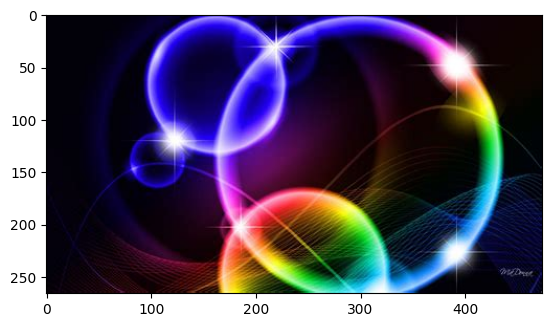

['placid', 'old timey art', 'fair world', 'peaceful', 'dark landscape']


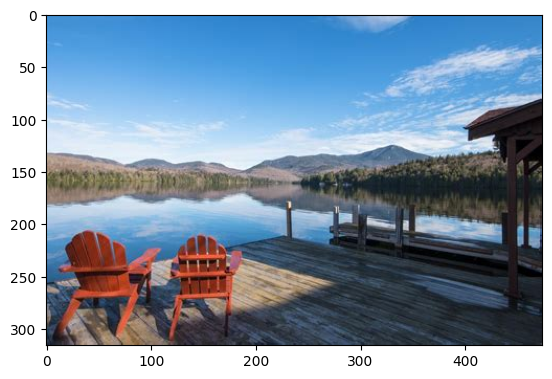

['old timey art', 'vintage', 'gloomy art', 'happy fantasy world', 'classical art']


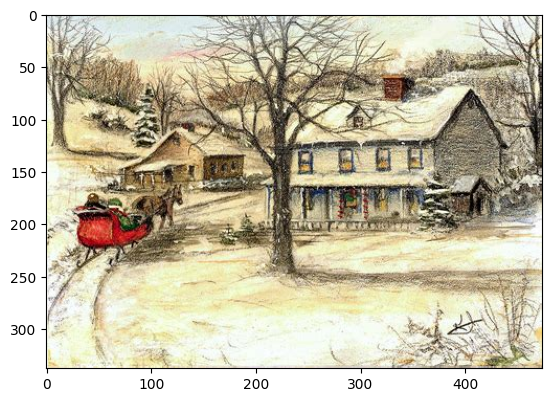

['colorful art', 'bright art', 'bright picture', 'peaceful art', 'cathedral']


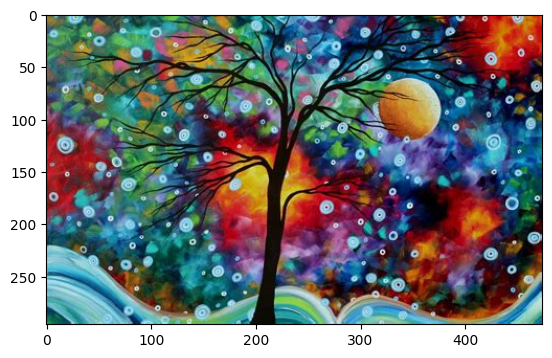

['bright landscape', 'peaceful landscape', 'bright picture', 'serene', 'peaceful art']


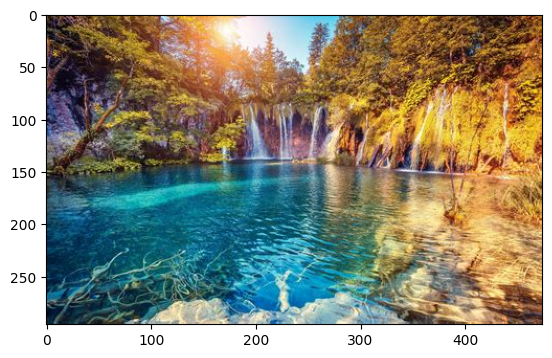

In [77]:
to_tensor = transforms.ToTensor()
for idx in range(5):
    i = np.random.randint(0, len(eval_data))
    img, label = eval_data[i]
    inputs = feature_extractor(img, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        
    predictions = torch.topk(logits.flatten(), top_k).indices.cpu()
    
    preds = []
    for pred in predictions:
        preds.append(id2label[pred.item()])
    print(preds)
    plt.imshow(img)
    plt.show()